## Análise Comparativa: Dados de Treinamento vs. Sintéticos
<hr>

Este notebook compara os dados de teste (gerados com Faker) com dados sintéticos gerados pelo modelo CTGAN.

### 0. Configuração Inicial


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from faker import Faker
import random
import string

# Configuração de estilo
plt.style.use('ggplot')
sns.set_palette("husl")
%matplotlib inline

### 1. Carregamento dos Dados


In [3]:
# Carregar dados de treino e sintéticos

# Dados de Teste 
real_data = pd.read_csv(r'C:\Users\Suerdo\synthetic_data_generator\analysis\training_data\test_data.csv')

# Dados Sintéticos
synthetic_data = pd.read_csv(r'C:\Users\Suerdo\synthetic_data_generator\synthetic_data\synthetic_secure_data.csv')

# Exibir informações básicas
print("Dados Reais - Informações:")
print(real_data.info())
print("\nDados Sintéticos - Informações:")
print(synthetic_data.info())

Dados Reais - Informações:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Nome        200 non-null    object
 1   Nascimento  200 non-null    object
 2   CPF         200 non-null    object
 3   RG          200 non-null    object
 4   Endereço    200 non-null    object
 5   Telefone    200 non-null    object
 6   Login       200 non-null    object
 7   Senha       200 non-null    object
dtypes: object(8)
memory usage: 12.6+ KB
None

Dados Sintéticos - Informações:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Nome        1000 non-null   object
 1   Nascimento  1000 non-null   object
 2   CPF         1000 non-null   object
 3   RG          1000 non-null   object
 4   Endereço    1000 non-null   object
 5   

### 1.1 Estatísticas Descritivas


In [5]:
print("\nEstatísticas Descritivas - Dados Reais:")
print(real_data.describe(percentiles=[.25, .5, .75]))

print("\nEstatísticas Descritivas - Dados Sintéticos:")
print(synthetic_data.describe(percentiles=[.25, .5, .75]))


Estatísticas Descritivas - Dados Reais:
                       Nome  Nascimento             CPF         RG  \
count                   200         200             200        200   
unique                  200         200             200        200   
top     Dra. Larissa da Paz  1925-03-03  381.297.056-21  710352682   
freq                      1           1               1          1   

                                                 Endereço         Telefone  \
count                                                 200              200   
unique                                                200              200   
top     Travessa Henry Gabriel Nascimento, 137, Conjun...  (87) 94973-8239   
freq                                                    1                1   

            Login       Senha  
count         200         200  
unique        200         200  
top     dtsjs1026  x2X(wqqD&8  
freq            1           1  

Estatísticas Descritivas - Dados Sintéticos:
           

### 2. Jensen-Shannon Divergence

In [27]:
# Função para limpar e converter para numérico
def clean_to_numeric(doc):
    if pd.isna(doc):
        return None
    # Remove todos os caracteres não numéricos
    cleaned = ''.join(filter(str.isdigit, str(doc)))
    # Converte para int64 se não for vazio, caso contrário retorna NaN
    return pd.to_numeric(cleaned, errors='coerce') if cleaned else None

# Aplicando a ambas as colunas em ambos os DataFrames
for df in [real_data, synthetic_data]:
    for col in ['CPF', 'RG']:
        df[col] = df[col].apply(clean_to_numeric).astype('Int64')  # Usamos Int64 (com I maiúsculo) que suporta NaN

# Verificando o resultado
print("\nDados Reais - Tipos após conversão:")
print(real_data[['CPF', 'RG']].dtypes)

print("\nDados Sintéticos - Tipos após conversão:")
print(synthetic_data[['CPF', 'RG']].dtypes)


Dados Reais - Tipos após conversão:
CPF    Int64
RG     Int64
dtype: object

Dados Sintéticos - Tipos após conversão:
CPF    Int64
RG     Int64
dtype: object


In [29]:
# Cálculo para todas as colunas numéricas
results = {}
for col in real_data.select_dtypes(include=['float64', 'int64']).columns:
    # Remove valores NaN e normaliza as distribuições para histogramas comparáveis
    real_vals = real_data[col].dropna().values
    synth_vals = synthetic_data[col].dropna().values
    
    # Cria histogramas com os mesmos bins para comparação justa
    bins = np.histogram_bin_edges(np.concatenate([real_vals, synth_vals]), bins='auto')
    hist_real, _ = np.histogram(real_vals, bins=bins, density=True)
    hist_synth, _ = np.histogram(synth_vals, bins=bins, density=True)
    
    # Calcula JS-Divergence (entre 0 e 1)
    js_distance = jensenshannon(hist_real, hist_synth, base=2)
    results[col] = js_distance

# Exibe resultados
print("Divergência de Jensen-Shannon por coluna (0 = idêntico, 1 = máximo):")
pd.DataFrame.from_dict(results, orient='index', columns=['JS-Divergence']).sort_values(by='JS-Divergence')

Divergência de Jensen-Shannon por coluna (0 = idêntico, 1 = máximo):


,JS-Divergence
RG,0.127974
CPF,0.145700


Os valores de Divergência de Jensen-Shannon (JS), RG (0.127) e CPF (0.145), indicam uma boa similaridade entre os dados reais e sintéticos.

### 3. PCA

In [31]:
def prepare_for_dim_reduction(df):
    """Prepara dados para redução de dimensionalidade"""
    # Criar features numéricas
    df_copy = df.copy()
    df_copy['Nome_Length'] = df_copy['Nome'].apply(len)
    df_copy['Login_Length'] = df_copy['Login'].apply(len)
    df_copy['Endereco_Length'] = df_copy['Endereço'].apply(len)
    df_copy['Nascimento_Year'] = pd.to_datetime(df_copy['Nascimento']).dt.year
    
    # Selecionar apenas colunas numéricas
    numeric_cols = ['Nome_Length', 'Login_Length', 'Endereco_Length', 'Nascimento_Year']
    return df_copy[numeric_cols]

# Preparar dados
real_numeric = prepare_for_dim_reduction(real_data)
synthetic_numeric = prepare_for_dim_reduction(synthetic_data)

# Combinar dados para visualização
combined = pd.concat([real_numeric, synthetic_numeric])
combined['Type'] = ['Treino'] * len(real_numeric) + ['Sintético'] * len(synthetic_numeric)

# Normalizar
scaler = StandardScaler()
combined_scaled = scaler.fit_transform(combined.drop('Type', axis=1))

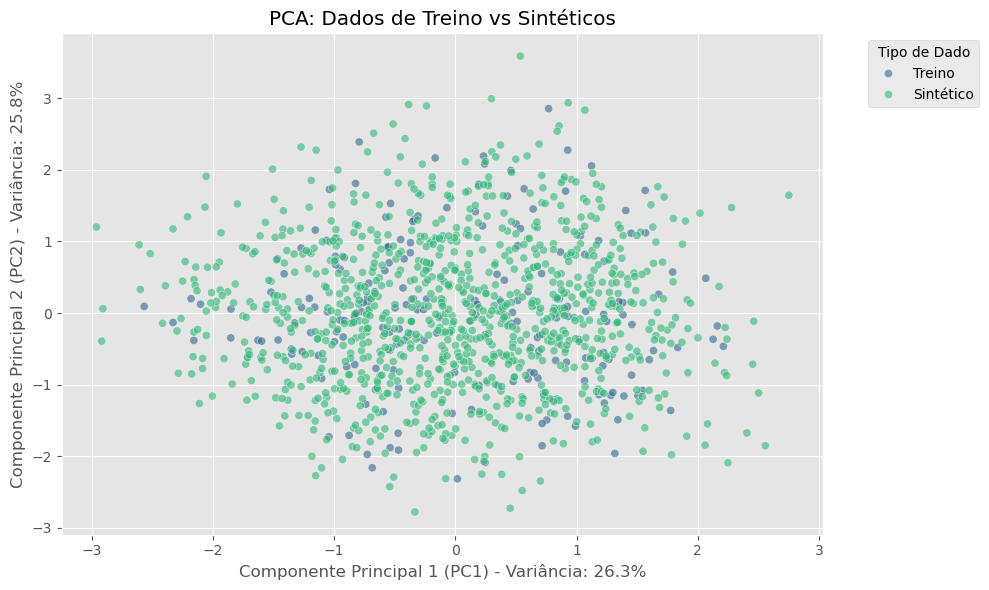

In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Aplicar PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(combined_scaled)

# Plotar os resultados
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    x=pca_results[:, 0], 
    y=pca_results[:, 1], 
    hue=combined['Type'], 
    alpha=0.6,
    palette='viridis'
)

# Adicionando rótulos e título
plt.xlabel('Componente Principal 1 (PC1) - Variância: {:.1f}%'.format(pca.explained_variance_ratio_[0]*100))
plt.ylabel('Componente Principal 2 (PC2) - Variância: {:.1f}%'.format(pca.explained_variance_ratio_[1]*100))
plt.title('PCA: Dados de Treino vs Sintéticos')

# Adicionar legenda
plt.legend(title='Tipo de Dado', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

A similaridade entre as variâncias de PC1 e PC2 sugere que múltiplas dimensões são igualmente importantes para descrever os dados. A sobreposição parcial das nuvens de pontos demonstra que o modelo foi capaz de capturar a estrutura multivariada dos dados originais. Além disso, a similaridade na distribuição global sugere que os dados sintéticos preservam as relações entre as variáveis, mantendo as características estatísticas essenciais do conjunto real.

### 4. t-SNE

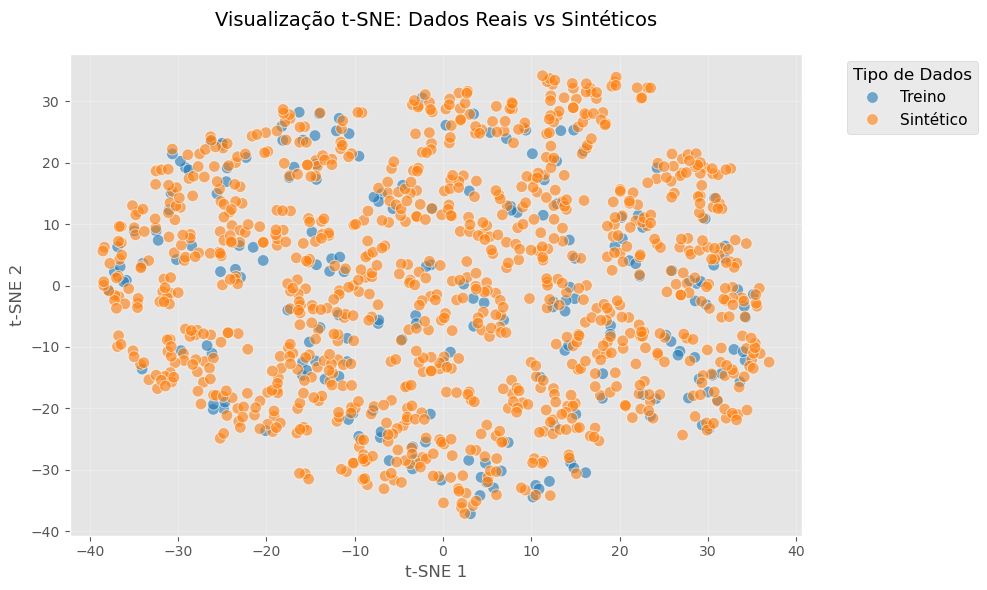

In [35]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Aplicar t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(combined_scaled)

# Plotar os resultados
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    x=tsne_results[:, 0], 
    y=tsne_results[:, 1], 
    hue=combined['Type'], 
    alpha=0.6,
    palette='tab10',
    s=70  # Tamanho dos pontos
)

# Configurações dos eixos e título
plt.xlabel('t-SNE 1', fontsize=12)
plt.ylabel('t-SNE 2', fontsize=12)
plt.title('Visualização t-SNE: Dados Reais vs Sintéticos', fontsize=14, pad=20)

# Melhorar a legenda
plt.legend(
    title='Tipo de Dados',
    title_fontsize='12',
    fontsize='11',
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

O gráfico t-SNE evidencia a preservação da estrutura dos dados originais, indicando que o CTGAN conseguiu capturar com sucesso as relações não-lineares entre as variáveis. A distribuição multivariada dos dados sintéticos foi replicada de forma convincente, reforçando a capacidade do modelo em manter a coerência estatística e estrutural do conjunto real.